In [ ]:
'''
Notes

в пределах 10мб - не мусорные контакты
всю Hi-C карту предсказывать не надо. участки вдоль диагонали

удалить главную диагональ? - схлопывать


TODO: реализовать RMSE и R^2 для численной оценки качества предсказаний моделей
Разделить на 80 training, 10 dev, 10 test
Посмотреть качество предсказаний на test set'е


TODO: 
Learn only on upper triangle (2 times less output values, should be faster). 
Then, after prediction, form 2d matrix from upper triangle

TODO:
Use all chromosomes (not only one) for training and testing NN


TODO:
To reduce overfitting and increase generalization
stochastically shift input sequences by up to +/- 11 bp and reverse complement the DNA and flip the Hi-C map.
(described in Fudenberg)


Refactoring is needed!


'''

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

pandas.set_option('display.max_columns', 500)
pandas.set_option('display.max_rows', 500)

import h5py
import random

import math
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import cooler
import cooltools as ct

from Bio import SeqIO

import pickle

import scipy
import os
import re

In [2]:
# the following directive activates inline plotting
%matplotlib inline

# allow to allocate resources for model training
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

In [3]:
from tensorflow.keras.backend import set_session
sess = tf.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [4]:
# Constants

# Training set formation
WINDOW_SIZE = 526
STRIDE = 526 // 2

In [5]:
# UTIL FUNCTIONS

In [6]:
def plot_hic(matrix, use_log_scale = False, chromosome_position = ()):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    if use_log_scale:
        im = ax.matshow(np.log10(matrix), cmap='YlOrRd')
        fig.colorbar(im)
    else:
        im = ax.matshow(matrix, cmap='YlOrRd')
        fig.colorbar(im)
    
    if len(chromosome_position) != 0:
        ax.set_title(f"{chromosome_position[0]}: {chromosome_position[1][0]}-{chromosome_position[1][1]}", fontsize=25)

In [7]:
def one_hot_dna(sequences = {}):
    for k,v in sequences.items():
        seq_array = np.array(list(v))

        label_encoder = LabelEncoder()
        integer_encoded_seq = label_encoder.fit_transform(seq_array)

        integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)

        onehot_encoder = OneHotEncoder(sparse = False)
        result = onehot_encoder.fit_transform(integer_encoded_seq)
        
        # if Ns are present in the DNA sequence, result will have 5 columns. We delete 4th column which has Ns
        # N row in the resulting training set will have all 0s
        if result.shape[1] == 5:
            result = np.delete(result, 3, 1)
        
        sequences[k] = result

In [8]:
def select_training_squares(hic_library, chroms):
    training_set = {}

    COLAB_OFFSET = 526 # offset from the transformation step from the Google Colab
    for chrom in chroms:
        current_chrom = hic_library[chrom]
        training_set[chrom] = []
        
        for part_number in sorted(current_chrom.keys()):
            current_chrom_part = current_chrom[part_number]
            
            offset = (part_number - 1) * COLAB_OFFSET
            
            for i in range(WINDOW_SIZE, current_chrom_part.shape[0] + 1, STRIDE):
                training_set[chrom].append((current_chrom_part[i - WINDOW_SIZE:i, i - WINDOW_SIZE:i],
                                          (offset + (i - WINDOW_SIZE), offset + i)))
            
    return training_set

In [9]:
def form_train_x(sequences_one_hot, chroms, training_squares, train_indices):
    train_x = []
    count = 0
    
    CROPPING_FACTOR_DNA = 856
    
    for chrom in chroms:
        cur_seq = sequences_one_hot[chrom]
        cur_training_squares = training_squares[chrom]

        for training_square in cur_training_squares:
            sq_begin, sq_end = training_square[1]
            
            if count in train_indices:
                # crop train_x to match 524288
                train_x.append(cur_seq[(sq_begin * 1000) + CROPPING_FACTOR_DNA:(sq_end * 1000) - CROPPING_FACTOR_DNA, :])

            count += 1
            
    return np.asarray(train_x)

In [10]:
def form_train_y(training_squares, chroms, train_indices):
    train_y = []
    count = 0
    
    for chrom in chroms:            
        cur_training_squares = training_squares[chrom]

        for training_square in cur_training_squares:
            CROPPING_TARGET = 7
            cropped_training_square = training_square[0][CROPPING_TARGET:training_square[0].shape[0] - CROPPING_TARGET, 
                                                         CROPPING_TARGET:training_square[0].shape[1] - CROPPING_TARGET]

            upper_triu = to_upper_triu(cropped_training_square, diagonal_offset=2)
            
            if count in train_indices:
                train_y.append(upper_triu)
                
            count += 1   
            
    return np.asarray(train_y)

In [11]:
def to_upper_triu(input_matrix, diagonal_offset = 2):
    seq_len = input_matrix.shape[0]
    return input_matrix[np.triu_indices(seq_len, diagonal_offset)].reshape([-1, 1])

In [12]:
# Colab specific code
# filepath = "drive/My Drive/Colab Notebooks/S2-Wang2017-async.dm3.mapq_30.100.mcool"

filepath = "S2-Wang2017-async.dm3.mapq_30.100.mcool"

resolution = "::/resolutions/1000" # 1 KB resolution
c = cooler.Cooler(filepath + resolution)

chroms = c.chromnames
# don't use these small chromosomes
chroms.remove("chrM")
chroms.remove("chr4")

In [ ]:
# DON'T RUN, LOAD TRANSFORMED Hi-C INSTEAD
for chrom in chroms:
    arr = c.matrix(balance=True).fetch(chrom)
    # For adaptive coarse-grain transformation purposes
    arr_raw = c.matrix(balance=False).fetch(chrom)
    
    transformed_arr = transform_hic(arr, arr_raw)
    file_name = chrom + "_transformed.npy"
    np.save(f"./transformed_hic/{file_name}", transformed_arr)

In [ ]:
plot_hic(arr, use_log_scale = True)

In [ ]:
# Load all transformed Hi-C
transformed_hic = {}
for chrom in chroms:
    chrom_hic_filenames = [filename for filename in os.listdir('./transformed_hic') if filename.startswith(chrom)]
    
    if len(chrom_hic_filenames) > 0:
        chrom_parts = {}
        for filename in chrom_hic_filenames:
            current_part_number = int(re.search("(transformed)(\d+)", filename).group(2))
            chrom_parts[current_part_number] = np.load(f"./transformed_hic/{filename}")['arr_0']

        transformed_hic[chrom] = chrom_parts

In [ ]:
training_squares = select_training_squares(transformed_hic, chroms)

In [ ]:
sequences = {}
for chrom in chroms:
    fasta_sequence = list(SeqIO.parse(open(f"./chromFa/{chrom}.fa"),'fasta'))[0]
    sequences[chrom] = str(fasta_sequence.seq)

In [ ]:
# Воспринимаю маленькие и большие буквы одинаковым образом
for k in sequences.keys():
    sequences[k] = sequences[k].upper()

In [ ]:
# For later use (augmentation)
sequences_orig = sequences.copy()

In [ ]:
# Преобразую последовательности в one-hot encoding (A = 0, C = 1, G = 2, T = 3)
one_hot_dna(sequences)

In [ ]:
# split 60/40 - train/test

In [ ]:
# train_indices = np.random.choice(1836, 1150, replace = False) 
# 1150 - is 60 percent of the whole dataset
# np.save("./train_indices.npy", train_indices)

# LOAD FROM THE MEMORY
train_indices = np.load("./train_test_data/train_indices.npy")

In [ ]:
train_indices = np.load("./train_test_data/train_indices.npy")
test_indices = np.load("./train_test_data/test_indices.npy")

In [ ]:
len(train_indices)

In [ ]:
len(test_indices)

In [ ]:
test_x = form_train_x(sequences, chroms, training_squares, test_indices)
test_y = form_train_y(training_squares, chroms, test_indices)

In [ ]:
np.savez_compressed("./test_x.npz", test_x)

In [ ]:
np.savez_compressed("./test_y.npz", test_y)

In [ ]:
train_x = form_train_x(sequences, chroms, training_squares, train_indices)

In [ ]:
train_x.shape

In [ ]:
np.savez_compressed("./train_x.npz", train_x)

In [ ]:
train_y = form_train_y(training_squares, chroms, train_indices)

In [ ]:
train_y.shape

In [ ]:
np.savez_compressed("./train_y.npz", train_y)

In [ ]:
# Convnet model (similar to Fudenberg NN):

model_m = Sequential()

model_m.add(layers.Conv1D(25, 50, activation='relu', input_shape=(50000, 4)))
model_m.add(layers.Conv1D(25, 50, activation='relu'))
model_m.add(layers.MaxPooling1D(5, strides = 2))

model_m.add(layers.Conv1D(50, 25, activation='relu'))
model_m.add(layers.MaxPooling1D(5, strides = 2))

model_m.add(layers.Conv1D(50, 25, activation='relu'))
model_m.add(layers.MaxPooling1D(20, strides = 4))

model_m.add(layers.Conv1D(70, 20, activation='relu'))
model_m.add(layers.MaxPooling1D(25, strides = 4))

# dilated layers
model_m.add(layers.Conv1D(100, 15, activation='relu', dilation_rate = 2))
model_m.add(layers.Conv1D(100, 15, activation='relu', dilation_rate = 2))
model_m.add(layers.MaxPooling1D(25, strides = 4))

model_m.add(layers.Flatten())
model_m.add(layers.Dense(2500, activation='linear'))

# здесь можно не использовать входы (50 штук) и схлопывать после предсказания НС
# не 2.500, а 2.450
# для тренировки и для предсказаний надо будет сначала делать трансформацию для вектора

print(model_m.summary())

In [ ]:
model_m.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='mse',
              metrics=['mae'])

In [ ]:
history = model_m.fit(train_x,
                      train_y,
                      batch_size=32,
                      epochs=3,
                      verbose=1)

In [ ]:
model_m.load_weights('project2_model_1.h5')

In [ ]:
plot_hic(training_squares[0][0])

In [ ]:
sq_begin, sq_end = training_squares[0][1]
seq_to_use = current_seq_one_hot[(sq_begin * 1000):(sq_end * 1000), ].reshape((1,50000, 4))

In [ ]:
prediction = model_m.predict(seq_to_use)

In [ ]:
plot_hic(prediction.reshape((50, 50)))

In [ ]:
model_m.load_weights('project2_model_2.h5')

In [ ]:
plot_hic(training_squares[3][0])

In [ ]:
sq_begin, sq_end = training_squares[3][1]
seq_to_use = current_seq_one_hot[(sq_begin * 1000):(sq_end * 1000), ].reshape((1,50000, 4))

In [ ]:
prediction = model_m.predict(seq_to_use)

In [ ]:
plot_hic(prediction.reshape((50, 50)))

In [ ]:
# Fudenberg избавляется от scaling'а
# избавиться от шкалирования. полимерное свойство хроматина нам не обязательно выучивать
# Нам надо это делать:
# observed/expected - Саша отправит
# можно применять observed/expected для всей хромосомы или для каждого квардрата 50x50
# для каждого квардрата делать observed/expected

In [ ]:
# Басет работа - 2015 (размеры слоев и параметры оттуда)
# В басет предсказывается DNA sequence -> accessibility (open versus closed chromatin) of this area 
# (in different cell types)

In [ ]:
# Convnet model (similar to Basset NN):
# Basset NN is not trainable in a reasonable time with this 50x50 window size -> reduced to 25x25 window size
# Nevertheless, 3 times more tunable parameters than Fudenberg

model_m = Sequential()

model_m.add(layers.Conv1D(300, 21, activation='relu', input_shape=(25000, 4)))
model_m.add(layers.MaxPooling1D(4))

model_m.add(layers.Conv1D(300, 6, activation='relu'))
model_m.add(layers.MaxPooling1D(4))

model_m.add(layers.Conv1D(500, 4, activation='relu'))
model_m.add(layers.MaxPooling1D(4))

model_m.add(layers.Flatten())

model_m.add(layers.Dense(1000, activation='relu'))

model_m.add(layers.Dense(625, activation='linear'))

print(model_m.summary())

In [ ]:
model_m.load_weights('project2_model_Basset.h5')

In [ ]:
plot_hic(training_squares[3][0])

In [ ]:
sq_begin, sq_end = training_squares[3][1]
seq_to_use = current_seq_one_hot[(sq_begin * 1000):(sq_end * 1000), ].reshape((1,25000, 4))

In [ ]:
prediction = model_m.predict(seq_to_use)

In [ ]:
plot_hic(prediction.reshape((25, 25)))

In [ ]:
# Hi-C tranformations

In [ ]:
plot_hic(arr[0:1000, 0:1000], use_log_scale=True)

In [ ]:
# Step 1: Adaptive coarse-grain
transformed_arr = ct.lib.numutils.adaptive_coarsegrain(arr[0:1000, 0:1000], arr_raw[0:1000, 0:1000])

In [ ]:
plot_hic(transformed_arr, use_log_scale=True)

In [ ]:
# Step 2: Normalize the contact matrix for distance-dependent contact decay.
# Observed/Expected
transformed_arr, _, _, _ = ct.lib.numutils.observed_over_expected(transformed_arr, mask = ~np.isnan(transformed_arr))

In [ ]:
plot_hic(transformed_arr, use_log_scale=True)

In [ ]:
# Step 3: Take natural logarithm
transformed_arr = np.log(transformed_arr)

In [ ]:
plot_hic(transformed_arr)

In [ ]:
# Step 4: Interpolate all NaN values
transformed_arr = ct.lib.numutils.interp_nan(transformed_arr)

In [ ]:
plot_hic(transformed_arr)

In [ ]:
# Step 5: Use Gaussian filter
# To get rid of noise, emphasizing larger patterns.
transformed_arr = scipy.ndimage.gaussian_filter(transformed_arr, sigma = 1)

In [ ]:
plot_hic(transformed_arr)

In [ ]:
# combine all the transformations in one function
def transform_hic(hic_matrix, hic_matrix_raw):
    transformed_arr = ct.lib.numutils.adaptive_coarsegrain(hic_matrix, hic_matrix_raw)
    transformed_arr, _, _, _ = ct.lib.numutils.observed_over_expected(transformed_arr, mask = ~np.isnan(transformed_arr))
    transformed_arr = np.log(transformed_arr)
    transformed_arr = ct.lib.numutils.interp_nan(transformed_arr)
    transformed_arr = scipy.ndimage.gaussian_filter(transformed_arr, sigma = 1)
    
    return transformed_arr

In [ ]:
plot_hic(arr[0:4000, 0:4000], use_log_scale=True)

In [ ]:
plot_hic(transform_hic(arr[2500:3000, 2500:3000], arr_raw[2500:3000, 2500:3000]))

In [ ]:
# TODO: RMSE and R^2. split on train and test

In [ ]:
# (None, 5, 3) -> (None, 5, 5, 3)
# Explanation of the 1D -> 2D procedure

oned = tf.constant([[[1, 6, 11], 
                     [2, 7, 12], 
                     [3, 8, 13],
                     [4, 9, 14],
                     [5, 10, 15]],
                   
                    [[1, 6, 11], 
                     [2, 7, 12], 
                     [3, 8, 13],
                     [4, 9, 14],
                     [5, 10, 15]],
                   
                    [[1, 6, 11], 
                     [2, 7, 12], 
                     [3, 8, 13],
                     [4, 9, 14],
                     [5, 10, 15]]])

_, seq_len, features = oned.shape
twod1 = tf.tile(oned, [1, seq_len, 1])
twod1 = tf.reshape(twod1, [-1, seq_len, seq_len, features])
twod2 = tf.transpose(twod1, [0,2,1,3])

with tf.Session() as sess:
    print("Original tiled tensor for one 1D filter (1D filter expanded 5 times)")
    print(np.array(sess.run([twod1]))[0][0][:, :, 0])
    
    print("Transposed tiled tensor")
    print(np.array(sess.run([twod2]))[0][0][:, :, 0])


twod1 = tf.expand_dims(twod1, axis=-1)
twod2 = tf.expand_dims(twod2, axis=-1)
twod  = tf.concat([twod1, twod2], axis=-1)
twod = tf.reduce_mean(twod, axis=-1)


with tf.Session() as sess:
    print("Result of mean operation between original and transposed (mean between each pair of values in 1D filter)")
    print(np.array(sess.run([twod]))[0][0][:, :, 0])

In [ ]:
# Exlanation of ConcatDist2D procedure
# This layer adds one more channel which contains pairwise distances for the matrices obtained on the previous layer
# (this should enhance model performance)
# (None, 5, 5, 3) -> (None, 5, 5, 4)

# For one training example -> (1,5,5,3)
inputs = tf.random.uniform(shape=[1,5,5,3])

input_shape = tf.shape(inputs)
batch_size, seq_len = input_shape[0], input_shape[1]

## concat 2D distance ##
pos = tf.expand_dims(tf.range(0, seq_len), axis=-1)
matrix_repr1 = tf.tile(pos, [1,seq_len])
matrix_repr2 = tf.transpose(matrix_repr1, [1,0])
dist  = tf.math.abs( tf.math.subtract(matrix_repr1, matrix_repr2) )
dist = tf.dtypes.cast(dist, tf.float32)
dist = tf.expand_dims(dist, axis=-1)
dist = tf.expand_dims(dist, axis=0)
dist = tf.tile(dist, [batch_size, 1, 1, 1])

res = tf.concat([inputs, dist], axis=-1)

with tf.Session() as sess:
    print(np.array(sess.run([res]))[0, :, :, :, 3])

In [ ]:
###########################
# Custom Keras layers
###########################

In [13]:
class OneToTwo(tf.keras.layers.Layer):
    ''' Transform 1d to 2d with i,j vectors operated on.'''
    def __init__(self, operation='mean'):
        super(OneToTwo, self).__init__()
        self.operation = operation.lower()

    def call(self, oned):
        _, seq_len, features = oned.shape

        twod1 = tf.tile(oned, [1, seq_len, 1])
        twod1 = tf.reshape(twod1, [-1, seq_len, seq_len, features])
        twod2 = tf.transpose(twod1, [0,2,1,3])

        twod1 = tf.expand_dims(twod1, axis=-1)
        twod2 = tf.expand_dims(twod2, axis=-1)
        twod  = tf.concat([twod1, twod2], axis=-1)
        twod = tf.reduce_mean(twod, axis=-1)

        return twod

    def get_config(self):
        config = super().get_config().copy()
        config['operation'] = self.operation
        return config

In [14]:
class ConcatDist2D(tf.keras.layers.Layer):
    ''' Concatenate the pairwise distance to 2d feature matrix.'''
    def __init__(self):
        super(ConcatDist2D, self).__init__()

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, seq_len = input_shape[0], input_shape[1]

        ## concat 2D distance ##
        pos = tf.expand_dims(tf.range(0, seq_len), axis=-1)
        matrix_repr1 = tf.tile(pos, [1, seq_len])
        matrix_repr2 = tf.transpose(matrix_repr1, [1, 0])
        dist = tf.math.abs(tf.math.subtract(matrix_repr1, matrix_repr2))
        dist = tf.dtypes.cast(dist, tf.float32)
        dist = tf.expand_dims(dist, axis=-1)
        dist = tf.expand_dims(dist, axis=0)
        dist = tf.tile(dist, [batch_size, 1, 1, 1])
        return tf.concat([inputs, dist], axis=-1)


In [15]:
class Symmetrize2D(tf.keras.layers.Layer):
    '''Take the average of a matrix and its transpose to enforce symmetry.'''

    def __init__(self):
        super(Symmetrize2D, self).__init__()

    def call(self, x):
        x_t = tf.transpose(x, [0, 2, 1, 3])
        x_sym = (x + x_t) / 2
        return x_sym

In [16]:
class UpperTri(tf.keras.layers.Layer):
    ''' Unroll matrix to its upper triangular portion.'''

    def __init__(self, diagonal_offset=2):
        super(UpperTri, self).__init__()
        self.diagonal_offset = diagonal_offset

    def call(self, inputs):
        seq_len = inputs.shape[1].value
        output_dim = inputs.shape[-1]

        triu_tup = np.triu_indices(seq_len, self.diagonal_offset)
        triu_index = list(triu_tup[0] + seq_len * triu_tup[1])
        unroll_repr = tf.reshape(inputs, [-1, seq_len ** 2, output_dim])
        return tf.gather(unroll_repr, triu_index, axis=1)

    def get_config(self):
        config = super().get_config().copy()
        config['diagonal_offset'] = self.diagonal_offset
        return config

In [17]:
class StochasticReverseComplement(tf.keras.layers.Layer):
    """Stochastically reverse complement a one hot encoded DNA sequence."""

    def __init__(self):
        super(StochasticReverseComplement, self).__init__()

    def call(self, seq_1hot, training=None):
        if training:
            rc_seq_1hot = tf.gather(seq_1hot, [3, 2, 1, 0], axis=-1)
            rc_seq_1hot = tf.reverse(rc_seq_1hot, axis=[1])
            reverse_bool = tf.random.uniform(shape=[]) > 0.5
            src_seq_1hot = tf.cond(reverse_bool, lambda: rc_seq_1hot, lambda: seq_1hot)
            return src_seq_1hot, reverse_bool
        else:
            return seq_1hot, tf.constant(False)

In [18]:
class StochasticShift(tf.keras.layers.Layer):
    """Stochastically shift a one hot encoded DNA sequence."""

    def __init__(self, shift_max=0, pad='uniform'):
        super(StochasticShift, self).__init__()
        self.shift_max = shift_max
        self.augment_shifts = tf.range(-self.shift_max, self.shift_max + 1)
        self.pad = pad

    def call(self, seq_1hot, training=None):
        if training:
            shift_i = tf.random.uniform(shape=[], minval=0, dtype=tf.int64,
                                        maxval=len(self.augment_shifts))
            shift = tf.gather(self.augment_shifts, shift_i)
            sseq_1hot = tf.cond(tf.not_equal(shift, 0),
                                lambda: shift_sequence(seq_1hot, shift),
                                lambda: seq_1hot)
            return sseq_1hot
        else:
            return seq_1hot

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'shift_max': self.shift_max,
            'pad': self.pad
        })
        return config


def shift_sequence(seq, shift, pad_value=0.25):
    """Shift a sequence left or right by shift_amount.
    Args:
    seq: [batch_size, seq_length, seq_depth] sequence
    shift: signed shift value (tf.int32 or int)
    pad_value: value to fill the padding (primitive or scalar tf.Tensor)
    """
    if seq.shape.ndims != 3:
        raise ValueError('input sequence should be rank 3')
    input_shape = seq.shape

    pad = pad_value * tf.ones_like(seq[:, 0:tf.abs(shift), :])

    def _shift_right(_seq):
        # shift is positive
        sliced_seq = _seq[:, :-shift:, :]
        return tf.concat([pad, sliced_seq], axis=1)

    def _shift_left(_seq):
        # shift is negative
        sliced_seq = _seq[:, -shift:, :]
        return tf.concat([sliced_seq, pad], axis=1)

    sseq = tf.cond(tf.greater(shift, 0),
                   lambda: _shift_right(seq),
                   lambda: _shift_left(seq))
    sseq.set_shape(input_shape)

    return sseq

In [19]:
class SwitchReverse(tf.keras.layers.Layer):
    """Reverse predictions if the inputs were reverse complemented."""

    def __init__(self):
        super(SwitchReverse, self).__init__()

    def call(self, x_reverse):
        x = x_reverse[0]
        reverse = x_reverse[1]

        xd = len(x.shape)
        if xd == 3:
            rev_axes = [1]
        elif xd == 4:
            rev_axes = [1, 2]
        else:
            raise ValueError('Cannot recognize SwitchReverse input dimensions %d.' % xd)

        return tf.keras.backend.switch(reverse,
                                       tf.reverse(x, axis=rev_axes),
                                       x)

In [20]:
###########################
# Helper functions
###########################

In [21]:
def activate(current, activation, verbose=False):
    if verbose: 
        print('activate:',activation)
    
    if activation == 'relu':
        current = tf.keras.layers.ReLU()(current)
    elif activation == 'gelu':
        current = GELU()(current)
    elif activation == 'sigmoid':
        current = tf.keras.layers.Activation('sigmoid')(current)
    elif activation == 'tanh':
        current = tf.keras.layers.Activation('tanh')(current)
    elif activation == 'exp':
        current = Exp()(current)
    elif activation == 'softplus':
        current = Softplus()(current)
    else:
        print('Unrecognized activation "%s"' % activation, file=sys.stderr)
        exit(1)

    return current

In [22]:
###########################
# Keras blocks
###########################

In [23]:
def conv_block(inputs, filters=None, kernel_size=1, activation='relu', strides=1,
    dilation_rate=1, l2_scale=0, dropout=0, conv_type='standard', residual=False,
    pool_size=1, batch_norm=False, bn_momentum=0.99, bn_gamma=None,
    kernel_initializer='he_normal'):
  
    """Construct a single convolution block.
    Args:
    inputs:        [batch_size, seq_length, features] input sequence
    filters:       Conv1D filters
    kernel_size:   Conv1D kernel_size
    activation:    relu/gelu/etc
    strides:       Conv1D strides
    dilation_rate: Conv1D dilation rate
    l2_scale:      L2 regularization weight.
    dropout:       Dropout rate probability
    conv_type:     Conv1D layer type
    residual:      Residual connection boolean
    pool_size:     Max pool width
    batch_norm:    Apply batch normalization
    bn_momentum:   BatchNorm momentum
    bn_gamma:      BatchNorm gamma (defaults according to residual)
    Returns:
    [batch_size, seq_length, features] output sequence
    """

    # flow through variable current
    current = inputs

    # choose convolution type
    if conv_type == 'separable':
        conv_layer = tf.keras.layers.SeparableConv1D
    else:
        conv_layer = tf.keras.layers.Conv1D

    if filters is None:
        filters = inputs.shape[-1]

    # activation
    current = activate(current, activation)

    # convolution
    current = conv_layer(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding='same',
        use_bias=False,
        dilation_rate=dilation_rate,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=tf.keras.regularizers.l2(l2_scale))(current)

    # batch norm
    if batch_norm:
        if bn_gamma is None:
            bn_gamma = 'zeros' if residual else 'ones'
        
        current = tf.keras.layers.BatchNormalization(momentum=bn_momentum, gamma_initializer=bn_gamma, fused=True)(current)

    # dropout
    if dropout > 0:
        current = tf.keras.layers.Dropout(rate=dropout)(current)

    # residual add
    if residual:
        current = tf.keras.layers.Add()([inputs,current])

    # Pool
    if pool_size > 1:
        current = tf.keras.layers.MaxPool1D(pool_size=pool_size, padding='same')(current)

    return current

In [24]:
def conv_tower(inputs, filters_init, filters_mult=1, repeat=1, **kwargs):
    """Construct a reducing convolution block.
    Args:
    inputs:        [batch_size, seq_length, features] input sequence
    filters_init:  Initial Conv1D filters
    filters_mult:  Multiplier for Conv1D filters
    repeat:        Conv block repetitions
    Returns:
    [batch_size, seq_length, features] output sequence
    """

    # flow through variable current
    current = inputs

    # initialize filters
    rep_filters = filters_init

    for ri in range(repeat):
        # convolution
        current = conv_block(current, filters=int(np.round(rep_filters)), **kwargs)

    # update filters
    rep_filters *= filters_mult

    return current

In [25]:
def dilated_residual(inputs, filters, kernel_size=3, rate_mult=2, conv_type='standard', 
                     dropout=0, repeat=1, round=False, **kwargs):
    """Construct a residual dilated convolution block.
    Args:
    Returns:
    """

    # flow through variable current
    current = inputs

    # initialize dilation rate
    dilation_rate = 1.0

    for ri in range(repeat):
        # For skip connection purpose
        rep_input = current

        # dilate
        current = conv_block(current, filters=filters, kernel_size=kernel_size, 
                             dilation_rate=int(np.round(dilation_rate)), 
                             conv_type=conv_type, bn_gamma='ones', **kwargs)

        # return
        current = conv_block(current, filters=int(rep_input.shape[-1]), dropout=dropout, bn_gamma='zeros', **kwargs)

        # residual add
        current = tf.keras.layers.Add()([rep_input, current])

        # update dilation rate
        dilation_rate *= rate_mult
        
        if round:
            dilation_rate = np.round(dilation_rate)

    return current


In [26]:
# 2D related blocks

def concat_dist_2d(inputs, **kwargs):
    current = ConcatDist2D()(inputs)
    return current

def one_to_two(inputs, operation='mean', **kwargs):
    current = OneToTwo(operation)(inputs)
    return current

In [27]:
def conv_block_2d(inputs, filters=128, activation='relu', conv_type='standard',
    kernel_size=1, strides=1, dilation_rate=1, l2_scale=0, dropout=0, pool_size=1,
    batch_norm=False, bn_momentum=0.99, bn_gamma='ones', symmetric=False):

    """Construct a single 2D convolution block.   """

    # flow through variable current
    current = inputs

    # activation
    current = activate(current, activation)

  # choose convolution type
    if conv_type == 'separable':
        conv_layer = tf.keras.layers.SeparableConv2D
    else:
        conv_layer = tf.keras.layers.Conv2D

    # convolution
    current = conv_layer(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding='same',
        use_bias=False,
        dilation_rate=dilation_rate,
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(l2_scale))(current)

    # batch norm
    if batch_norm:
        current = tf.keras.layers.BatchNormalization(
          momentum=bn_momentum,
          gamma_initializer=bn_gamma,
          fused=True)(current)

    # dropout
    if dropout > 0:
        current = tf.keras.layers.Dropout(rate=dropout)(current)

    # pool
    if pool_size > 1:
        current = tf.keras.layers.MaxPool2D(
          pool_size=pool_size,
          padding='same')(current)

    # symmetric
    if symmetric:
        current = layers.Symmetrize2D()(current)

    return current

In [28]:
def symmetrize_2d(inputs, **kwargs):
    return Symmetrize2D()(inputs)

In [29]:
def dilated_residual_2d(inputs, filters, kernel_size=3, rate_mult=2,
                        dropout=0, repeat=1, symmetric=True, **kwargs):
    """Construct a residual dilated convolution block.
    """

    # flow through variable current
    current = inputs

    # initialize dilation rate
    dilation_rate = 1.0

    for ri in range(repeat):
        rep_input = current

        # dilate
        current = conv_block_2d(current,
                                filters=filters,
                                kernel_size=kernel_size,
                                dilation_rate=int(np.round(dilation_rate)),
                                bn_gamma='ones',
                                **kwargs)

        # return
        current = conv_block_2d(current,
                                filters=int(rep_input.shape[-1]),
                                dropout=dropout,
                                bn_gamma='zeros',
                                **kwargs)

        # residual add
        current = tf.keras.layers.Add()([rep_input, current])

        # enforce symmetry
        if symmetric:
            current = Symmetrize2D()(current)

        # update dilation rate
        dilation_rate *= rate_mult

    return current

In [30]:
def cropping_2d(inputs, cropping, **kwargs):
    current = tf.keras.layers.Cropping2D(cropping)(inputs)
    return current

In [31]:
def upper_tri(inputs, diagonal_offset=2, **kwargs):
    current = UpperTri(diagonal_offset)(inputs)
    return current

In [32]:
def dense(inputs, units, activation='softplus', kernel_initializer='he_normal',
          l2_scale=0, l1_scale=0, **kwargs):
    
    current = tf.keras.layers.Dense(
        units=units,
        activation=activation,
        use_bias=True,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1_scale, l2_scale)
    )(inputs)
    
    return current

In [37]:
# Model


# Changed for SEQ_LENGTH = 512000

#SEQ_LENGTH = 512000
SEQ_LENGTH = 524288
sequence = tf.keras.Input(shape=(SEQ_LENGTH, 4), name='sequence')

current = sequence

# Augmentation - Enable it later (after good performance on the training set)
# current, reverse_bool = StochasticReverseComplement()(current)
# augment_shift = 11
# current = StochasticShift(augment_shift)(current)

# TRUNK:

# First 1D convolution
current = conv_block(current, filters=96, kernel_size=11, pool_size=2, batch_norm=True, bn_momentum=0.9265,
                     activation="relu")


# Change for repeat = 9

# Multiple (11) 1D convolutions in a tower to arrive to 2048bp representation in 1D vectors
current = conv_tower(current, filters_init=96, filters_mult=1.0, kernel_size=5, pool_size=2, repeat=9, 
                     batch_norm=True, bn_momentum=0.9265, activation="relu")

# Dilated residual layers
current = dilated_residual(current, filters=48, rate_mult=1.75, repeat=8, dropout=0.4, batch_norm=True, 
                           bn_momentum=0.9265, activation="relu")

# Bottleneck 1D convolution
current = conv_block(current, filters=64, kernel_size=5, batch_norm=True, bn_momentum=0.9265,
                     activation="relu")

# final activation
current = activate(current, "relu")


# HEAD:
current = one_to_two(current)
current = concat_dist_2d(current)
current = conv_block_2d(current, filters=48, kernel_size=3, batch_norm=True, bn_momentum=0.9265,
                     activation="relu")

current = symmetrize_2d(current)
current = dilated_residual_2d(current, filters=24, kernel_size=3, rate_mult=1.75, repeat=6, dropout=0.1,
                              batch_norm=True, bn_momentum=0.9265, activation="relu")

# TODO: TRY WITHOUT CROP
#current = cropping_2d(current, cropping=26)

current = upper_tri(current, diagonal_offset=2)

current = dense(current, units=1, activation="linear")
#current = dense(current, units=5, activation="linear")

# current = SwitchReverse()([current, reverse_bool])

# make model
model = tf.keras.Model(inputs=sequence, outputs=current)

In [47]:
model_old = tf.keras.Model(inputs=sequence, outputs=current)

In [48]:
model_old.load_weights("./weights/model_advanced_weights_1.h5")

In [ ]:
# Try to predict on the test set

In [ ]:
model.save("./test_size.h5")

In [ ]:
test_x = form_train_x(sequences, chroms, training_squares, test_indices)
test_y = form_train_y(training_squares, chroms, test_indices)

In [ ]:
test_x.shape

In [ ]:
test_y.shape

In [ ]:
from cooltools.lib.numutils import set_diag

In [ ]:
FACTOR = 2

In [ ]:
to_pred1 = sequences['chr2L'][526000 * (FACTOR - 1):526000 * FACTOR,:].reshape(1, 526000, 4)[:, 856:(526000 - 856), :]

In [ ]:
chromosome_position1 = ('chr2L', (526000 * (FACTOR - 1) + 856, 526000 * FACTOR - 856))

In [ ]:
prediction1 = model.predict(to_pred1)

In [ ]:
prediction_matrix = from_upper_triu(prediction1)

In [ ]:
plot_hic(prediction_matrix, chromosome_position=chromosome_position1)

In [ ]:
arr = c.matrix(balance=True).fetch('chr2L')[(FACTOR - 1) * 526: FACTOR * 526, (FACTOR - 1) * 526: FACTOR * 526]
# For adaptive coarse-grain transformation purposes
arr_raw = c.matrix(balance=False).fetch('chr2L')[(FACTOR - 1) * 526: FACTOR * 526, (FACTOR - 1) * 526: FACTOR * 526]

transformed_arr_1 = transform_hic(arr, arr_raw)

In [ ]:
plot_hic(transformed_arr_1[7:526 - 7, 7:526 - 7], chromosome_position=chromosome_position1)

In [ ]:
FACTOR = 12

In [ ]:
to_pred2 = sequences['chr2R'][526000 * (FACTOR - 1):526000 * FACTOR,:].reshape(1, 526000, 4)[:, 856:(526000 - 856), :]

In [ ]:
chromosome_position2 = ('chr2R', (526000 * (FACTOR - 1) + 856, 526000 * FACTOR - 856))

In [ ]:
prediction2 = model.predict(to_pred2)

In [ ]:
prediction_matrix = from_upper_triu(prediction2)

In [ ]:
plot_hic(prediction_matrix, chromosome_position=chromosome_position2)

In [ ]:
arr = c.matrix(balance=True).fetch('chr2R')[(FACTOR - 1) * 526: FACTOR * 526, (FACTOR - 1) * 526: FACTOR * 526]
# For adaptive coarse-grain transformation purposes
arr_raw = c.matrix(balance=False).fetch('chr2R')[(FACTOR - 1) * 526: FACTOR * 526, (FACTOR - 1) * 526: FACTOR * 526]

transformed_arr_2 = transform_hic(arr, arr_raw)

In [ ]:
plot_hic(transformed_arr_2[7:526 - 7, 7:526 - 7], chromosome_position=chromosome_position2)

In [ ]:
FACTOR = 25

In [ ]:
to_pred3 = sequences['chr3L'][526000 * (FACTOR - 1):526000 * FACTOR,:].reshape(1, 526000, 4)[:, 856:(526000 - 856), :]

In [ ]:
chromosome_position3 = ('chr3L', (526000 * (FACTOR - 1) + 856, 526000 * FACTOR - 856))

In [ ]:
prediction3 = model.predict(to_pred3)

In [ ]:
prediction_matrix = from_upper_triu(prediction3)

In [ ]:
plot_hic(prediction_matrix, chromosome_position=chromosome_position3)

In [ ]:
arr = c.matrix(balance=True).fetch('chr3L')[(FACTOR - 1) * 526: FACTOR * 526, (FACTOR - 1) * 526: FACTOR * 526]
# For adaptive coarse-grain transformation purposes
arr_raw = c.matrix(balance=False).fetch('chr3L')[(FACTOR - 1) * 526: FACTOR * 526, (FACTOR - 1) * 526: FACTOR * 526]

transformed_arr_3 = transform_hic(arr, arr_raw)

In [ ]:
plot_hic(transformed_arr_3[7:526 - 7, 7:526 - 7], chromosome_position=chromosome_position3)

In [ ]:
CONST = 680

In [ ]:
seq_to_predict = test_x[CONST:(CONST+1), :, :]

In [ ]:
seq_to_predict

In [ ]:
prediction = model.predict(seq_to_predict)

In [ ]:
prediction_matrix = from_upper_triu(prediction)

In [ ]:
plot_hic(prediction_matrix)

In [ ]:
plot_hic(from_upper_triu(test_y[CONST:(CONST+1), :, :]))

In [ ]:
def from_upper_triu(vector_repr, matrix_len = 512, num_diags = 2):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr[0, :, 0]
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

In [ ]:
model.summary()

In [ ]:
# Model fitting

In [ ]:
optimizer_sgd = tf.keras.optimizers.SGD(
          lr=0.0065,
          momentum=0.99575,
          clipnorm=10.7)

model.compile(loss=tf.keras.losses.MSE,
                    optimizer=optimizer_sgd,
                    metrics=['mae']) # TODO: R^2 and Person custom metrics (? TensorBoard and EarlyStopping ?)

In [ ]:
history = model.fit(train_x,
                    train_y,
                    batch_size=2,
                    epochs=5,
                    verbose=1)

In [ ]:
# For now, we implement NN without stochastic shift and hi-c matrix flip
# this will help performance and is TODO
# Also Fudenberg trains on 5 datasets at the same time (Multi-task training). This improves accuracy on all dataset predictions

In [ ]:
# Убрать crop, уменьшить НС, multitask learning?

In [ ]:
##########################
# Fine-tuning method
##########################

In [ ]:
# у его one-hot-encoding - ACGT Порядок сделать у меня такой же (поменять training set)
# change training set to 512x512


import json
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.__version__)
if tf.__version__[0] == '1':
    tf.compat.v1.enable_eager_execution()

from cooltools.lib.numutils import set_diag
from basenji import dataset, dna_io, seqnn

In [ ]:
model_dir = "./basenji/"
params_file = model_dir+'params.json'
model_file  = model_dir+'model_best.h5'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']

seq_length = params_model['seq_length']
target_length = params_model['target_length']
target_crop = params_model['target_crop']
human_model = seqnn.SeqNN(params_model)

In [ ]:
human_model.restore(model_file)
print('successfully loaded')

In [ ]:
human_model = human_model.model

In [ ]:
human_model.summary()

In [ ]:
# Only relevant if model was compile 1 time
human_model.get_layer("conv1d_2") # layer from which we start copying weights
human_model.get_layer("batch_normalization_40") # layer at which we stop copying weights

In [ ]:
human_model_layers = []
for layer in human_model.layers[12:-7]:
    if 'conv1d' in layer.name or 'batch_normalization' in layer.name or 'conv2d' in layer.name:
        human_model_layers.append(layer)

In [ ]:
# My combined model

In [ ]:
SEQ_LENGTH = 524288
sequence = tf.keras.Input(shape=(SEQ_LENGTH, 4), name='sequence')

current = sequence

# Augmentation - Enable it later (after good performance on the training set)
# current, reverse_bool = StochasticReverseComplement()(current)
# augment_shift = 11
# current = StochasticShift(augment_shift)(current)

# First 1D convolution
current = conv_block(current, filters=96, kernel_size=11, pool_size=2, batch_norm=True, bn_momentum=0.9265,
                     activation="relu")

# Multiple (11) 1D convolutions in a tower to arrive to 1024bp representation in 1D vectors
current = conv_tower(current, filters_init=96, filters_mult=1.0, kernel_size=5, pool_size=2, repeat=9, 
                     batch_norm=True, bn_momentum=0.9265, activation="relu")

# Dilated residual layers
current = dilated_residual(current, filters=48, rate_mult=1.75, repeat=8, dropout=0.4, batch_norm=True, 
                           bn_momentum=0.9265, activation="relu")

# Bottleneck 1D convolution
current = conv_block(current, filters=64, kernel_size=5, batch_norm=True, bn_momentum=0.9265,
                     activation="relu")

# final activation
current = activate(current, "relu")


# HEAD:
current = one_to_two(current)
current = concat_dist_2d(current)
current = conv_block_2d(current, filters=48, kernel_size=3, batch_norm=True, bn_momentum=0.9265,
                     activation="relu")

current = symmetrize_2d(current)
current = dilated_residual_2d(current, filters=24, kernel_size=3, rate_mult=1.75, repeat=6, dropout=0.1,
                              batch_norm=True, bn_momentum=0.9265, activation="relu")

# TODO: TRY WITHOUT CROP
# current = cropping_2d(current, cropping=26)

current = upper_tri(current, diagonal_offset=2)

current = dense(current, units=1, activation="linear")
# current = dense(current, units=5, activation="linear")

# current = SwitchReverse()([current, reverse_bool])

# make model
drosophila_model = tf.keras.Model(inputs=sequence, outputs=current)

In [ ]:
drosophila_model.summary()

In [ ]:
optimizer_sgd = tf.keras.optimizers.SGD(
          lr=0.0065,
          momentum=0.99575,
          clipnorm=10.7)

drosophila_model.compile(loss=tf.keras.losses.MSE,
                    optimizer=optimizer_sgd,
                    metrics=['mae']) # TODO: R^2 and Person custom metrics (? TensorBoard and EarlyStopping ?)

In [ ]:
drosophila_model.fit(train_x,
                    train_y,
                    batch_size=2,
                    epochs=5,
                    verbose=1)

In [ ]:
train_x.shape

In [ ]:
train_y.shape

In [ ]:
524288 / 1000

In [ ]:
(526000 - 524288) / 2

In [ ]:
526 - 512

In [ ]:
# Алгоритм
# Берем последовательности ДНК 526.000. В нейронке (или в процессе формирования трен множества) клипаем их с двух сторон по 856 с каждой -> 524288
# Берем Hi-C 526x526 -> клипаем по 7 c каждой стороны -> 512

In [ ]:
# Set weights from the fudenberg model

In [ ]:
count = 0
for layer in drosophila_model.layers[6:]:
    if 'conv1d' in layer.name or 'batch_normalization' in layer.name or 'conv2d' in layer.name:
        layer.set_weights(human_model_layers[count].get_weights())
        count += 1

In [ ]:
##########################
# Data augmentation model
##########################

In [ ]:
# split 70/30 - train/test

# train_indices = np.random.choice(1836, 1300, replace = False)
# np.save("./train_test_data/v2/train_indices.npy", train_indices)

In [ ]:
# LOAD FROM THE MEMORY
train_indices = np.load("./train_test_data/v2/train_indices.npy")
test_indices = np.load("./train_test_data/v2/test_indices.npy")

In [ ]:
print(len(train_indices))
print(len(test_indices))

In [ ]:
# Original X
train_x = form_train_x(sequences, chroms, training_squares, train_indices)

np.savez_compressed("./train_test_data/v2/train_x.npz", train_x)

In [ ]:
# Reverse complement sequences

from Bio.Seq import Seq

sequences_reverse_complemented = dict()

for k,v in sequences_orig.items():
    sequences_reverse_complemented[k] = str(Seq(v).reverse_complement())

In [ ]:
one_hot_dna(sequences_reverse_complemented)

In [ ]:
# Reverse complemented
train_x_reverse_complemented = form_train_x(sequences_reverse_complemented, chroms, training_squares, train_indices)

np.savez_compressed("./train_test_data/v2/train_x_reverse_complemented.npz", train_x_reverse_complemented)

In [ ]:
# Original Y
train_y = form_train_y(training_squares, chroms, train_indices)

np.savez_compressed("./train_test_data/v2/train_y.npz", train_y)

In [ ]:
# Flip training_squares along the diagonal

import copy
flipped_training_squares = copy.deepcopy(training_squares)

for chrom in chroms:     
    cur_training_squares = training_squares[chrom]

    for i in range(len(cur_training_squares)):
        # convert to list to allow modifications
        flipped_training_squares[chrom][i] = list(flipped_training_squares[chrom][i])
        
        flipped_training_squares[chrom][i][0] = np.rot90(cur_training_squares[i][0], 2)

In [ ]:
plot_hic(training_squares['chrX'][152][0])

In [ ]:
plot_hic(flipped_training_squares['chrX'][152][0])

In [ ]:
# Flipped along diagonal
train_y_flipped = form_train_y(flipped_training_squares, chroms, train_indices)

np.savez_compressed("./train_test_data/v2/train_y_flipped.npz", train_y_flipped)

In [ ]:
# Merge Original and Reverse complement datasets into one dataset

In [ ]:
train_x_orig = np.load("./train_test_data/v2/train_x.npz")['arr_0']
train_x_reverse_complemented = np.load("./train_test_data/v2/train_x_reverse_complemented.npz")['arr_0']

In [ ]:
train_x_combined = np.concatenate((train_x_orig, train_x_reverse_complemented), axis=0)

In [ ]:
train_x_combined.shape

In [ ]:
train_y_orig = np.load("./train_test_data/v2/train_y.npz")['arr_0']
train_y_flipped = np.load("./train_test_data/v2/train_y_flipped.npz")['arr_0']

In [ ]:
train_y_combined = np.concatenate((train_y_orig, train_y_flipped), axis=0)

In [ ]:
train_y_combined.shape

In [ ]:
# Shuffle X and Y randomly

from sklearn.utils import shuffle

train_x_combined_shuffled, train_y_combined_shuffled = shuffle(train_x_combined, train_y_combined)

In [ ]:
# Split big dataset into 3 smaller datsets (because of Google Colab RAM capacity)

In [ ]:
splitted_x = np.split(train_x_combined_shuffled[0:2058, :, :], 3)
splitted_y = np.split(train_y_combined_shuffled[0:2058, :, :], 3)

In [ ]:
splitted_x[0].shape

In [ ]:
# Also, we add 4th dataset which combines small parts from 3 datasets -> to adress catastrophic forgetting issue
to_concatenate_from_x = []
to_concatenate_from_y = []

for i in range(3):
    random_choice = np.random.choice(686, int(686/3), replace = False)
    
    to_concatenate_from_x.append(splitted_x[i][random_choice])
    to_concatenate_from_y.append(splitted_y[i][random_choice])
    

splits_combination_x = np.concatenate(to_concatenate_from_x)
splits_combination_y = np.concatenate(to_concatenate_from_y)

In [ ]:
# save splitted datasets

for i in range(3):
    np.savez_compressed(f"./train_test_data/v2/splitted_dataset/train_x_part_{i}.npz", splitted_x[i])
    np.savez_compressed(f"./train_test_data/v2/splitted_dataset/train_y_part_{i}.npz", splitted_y[i])
    

np.savez_compressed(f"./train_test_data/v2/splitted_dataset/train_x_part_4.npz", splits_combination_x)
np.savez_compressed(f"./train_test_data/v2/splitted_dataset/train_y_part_4.npz", splits_combination_y)

In [ ]:
# Test set

In [ ]:
test_x = form_train_x(sequences, chroms, training_squares, test_indices)
test_y = form_train_y(training_squares, chroms, test_indices)

np.savez_compressed("./train_test_data/v2/test_x.npz", test_x)
np.savez_compressed("./train_test_data/v2/test_y.npz", test_y)

In [ ]:
# First predictions on the new model

In [41]:
test_x = np.load("./train_test_data/v2/test_x.npz")['arr_0']
test_y = np.load("./train_test_data/v2/test_y.npz")['arr_0']

In [42]:
print(test_x.shape)
print(test_y.shape)

(536, 524288, 4)
(536, 130305, 1)


In [80]:
model.load_weights("./weights/v2/model_80_epochs.h5")
# TODO: compare with 68 epochs model

In [ ]:
plot_hic(from_upper_triu(model.predict(test_x[0].reshape(1, 524288, 4))))

In [ ]:
plot_hic(from_upper_triu(model_old.predict(test_x[0].reshape(1, 524288, 4))))

In [ ]:
plot_hic(from_upper_triu(test_y[0].reshape(1, 130305, 1)))

In [ ]:
plot_hic(from_upper_triu(model.predict(test_x[130].reshape(1, 524288, 4))))

In [ ]:
plot_hic(from_upper_triu(model_old.predict(test_x[130].reshape(1, 524288, 4))))

In [ ]:
plot_hic(from_upper_triu(test_y[130].reshape(1, 130305, 1)))

In [ ]:
# Conclusion: New model's predictions are much more precise

In [ ]:
# Analyze augmented model weight checkpoints on the test set
# Pick the best weights of the augmented model

In [84]:
x = []
y = []

for filename in sorted(os.listdir("./weights/v2"), key=lambda filename: int(re.findall(r'\d+', filename)[0])):
    num_of_epochs = int(re.findall(r'\d+', filename)[0])
    x.append(num_of_epochs)
    
    model.load_weights(f"./weights/v2/{filename}")
    
    y.append(rmse(model, test_x, test_y))

In [85]:
print(x)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 48, 52, 56, 60, 64, 68, 72, 76, 80]


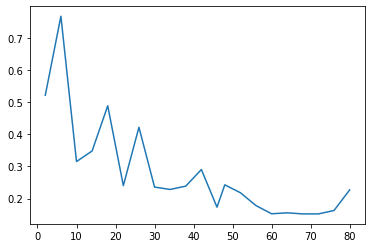

In [86]:
plt.plot(x, y)

In [ ]:
# Conclusion: optimal weights: at 70 epochs

In [43]:
from sklearn.metrics import mean_squared_error

def rmse(model, test_x, test_y, num_samples=50):
    avg_rmse = 0
    for i in range(num_samples):
        y_orig = test_y[i].tolist()
        y_pred = model.predict(test_x[i].reshape(1, 524288, 4)).reshape(130305, 1).tolist()
        
        avg_rmse += mean_squared_error(y_orig, y_pred)

    
    return avg_rmse / num_samples

In [ ]:
# RMSE analysis between old and new models

In [44]:
# 80 epochs
rmse(model, test_x, test_y)

0.22694600232189932

In [50]:
rmse(model_old, test_x, test_y)

0.3803311037028989

In [87]:
# 68 epochs - best model
model.load_weights("./weights/v2/model_68_epochs.h5")
rmse(model, test_x, test_y)

0.15209504571927068